In [116]:
import multiprocessing
import pathlib
import time

import click

from COVIDScenarioPipeline.SEIR import seir, setup
from COVIDScenarioPipeline.SEIR.utils import config
from COVIDScenarioPipeline.SEIR.profile import profile_options

#config.set_file(config_path)

config.set_file('config.yml')

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
scenario = 'LockdownUK_firstcase_5x'
nsim = 10
interactive = False
write_csv = False
write_parquet = True
index = 1



s = setup.Setup(setup_name=config["name"].get() + "_" + str(scenario),
                        spatial_setup=setup.SpatialSetup(
                            setup_name=spatial_config["setup_name"].get(),
                            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
                            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
                            popnodes_key=spatial_config["popnodes"].get(),
                            nodenames_key=spatial_config["nodenames"].get()
                        ),
                        nsim=nsim,
                        npi_scenario=scenario,
                        npi_config=config["interventions"]["settings"][scenario],
                        seeding_config=config["seeding"],
                        ti=config["start_date"].as_date(),
                        tf=config["end_date"].as_date(),
                        interactive=interactive,
                        write_csv=write_csv,
                        write_parquet=write_parquet,
                        dt=config["dt"].as_number(),
                        first_sim_index = index)


print(f"""
>> Scenario: {scenario}
>> Starting {s.nsim} model runs beginning from {s.first_sim_index}
>> Setup *** {s.setup_name} *** from {s.ti} to {s.tf}
>> writing to folder : {s.datadir}{s.setup_name}
    """)

onerun_SEIR_loadID = lambda sim_id2write, s, sim_id2load: seir.onerun_SEIR_loadID(int(sim_id2write), s, int(sim_id2load))
onerun_SEIR = lambda sim_id2write, s: seir.onerun_SEIR(int(sim_id2write), s)

Mobility files as matrices are not recommended. Please switch soon to long form csv files.


ValueError: mobility data must have dimensions of length of geodata (3143, 3143). Actual: (3221, 3221)

In [4]:
import pandas as pd
import glob, os, sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import multiprocessing
import pathlib
import time
from COVIDScenarioPipeline.SEIR.utils import config
import click


config.set_file('config.yml')

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
geodata_file=spatial_base_path / spatial_config["geodata"].get()
nodenames_key=spatial_config["nodenames"].get()
geodata = pd.read_csv(geodata_file, converters={nodenames_key: lambda x: str(x)})

folder = [x for x in Path('model_output/').glob('*') if not x.is_file()]

for fold in folder:
        print(f'loading {str(fold)[13:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            sim = pd.read_csv(filename)
            c = pd.concat([past_dynamics, sim])
            c.to_csv(filename)

        for filename in Path(str(fold)).rglob('*.parquet'):
            sim = pq.read_table(filename).to_pandas()
            #sim = sim.set_index('time', drop=True)
            c = pd.concat([past_dynamics, sim], ignore_index = True)
            #c['time'] = c.index
            only_in_sim = list(set(sim.columns) - set(past_dynamics.columns))
            only_in_pastdyn = list(set(past_dynamics.columns)- set(sim.columns))
            c.drop(only_in_pastdyn, inplace=True, axis=1)
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] != 'S'), only_in_sim] = 0
            pop_ois = []
            for nd in only_in_sim:
                pop_ois.append(float(geodata[geodata['geoid'] == nd].pop2010))
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] == 'S'), only_in_sim] = pop_ois
            pa_df = pa.Table.from_pandas(c, preserve_index = False)
            pa.parquet.write_table(pa_df,filename)
        print('DONE')

loading minimal_None ... DONE


In [62]:
            sim = pq.read_table('model_output/USA_Lockdown19181918_sandia/000000001.seir.parquet').to_pandas()
            #sim = sim.set_index('time', drop=True)
            c = pd.concat([past_dynamics, sim], ignore_index = True)
            #c['time'] = c.index
            only_in_sim = list(set(sim.columns) - set(past_dynamics.columns))
            only_in_pastdyn = list(set(past_dynamics.columns)- set(sim.columns))
            c.drop(only_in_pastdyn, inplace=True, axis=1)
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] != 'S'), only_in_sim] = 0
            pop_ois = []
            for nd in only_in_sim:
                pop_ois.append(float(geodata[geodata['geoid'] == nd].pop2010))
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] == 'S'), only_in_sim] = pop_ois

In [88]:
past_dynamics = pd.read_csv('data/past_dynamics.csv', parse_dates=['time'])
change_point = max(past_dynamics['time'])

c = past_dynamics.copy()

old_row = c[(c['time'] == min(c['time'])) & (c['comp'].isin(['I1','I2','I3','R']))].sum()

for t in c['time'].unique():
        new_row = c[(c['time'] == t) & (c['comp'].isin(['I1','I2','I3','R']))].sum()
        diffI_row = new_row.drop(['comp']) - old_row.drop(['comp'])
        
        diffI_row['comp'] = 'diffI'
        diffI_row['time'] = t
        c = c.append(diffI_row, ignore_index=True)
        old_row = new_row

In [89]:
c.sort_values(['time','comp'], ignore_index=True).round().to_csv('data/past_dynamics.csv')

TypeError: ufunc 'rint' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [148]:
c.isna().sum().max()

0

In [1]:
import pandas as pd
import glob, os, sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import multiprocessing
import pathlib
import time
from COVIDScenarioPipeline.SEIR.utils import config
import click


config.set_file('config.yml')

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
geodata_file=spatial_base_path / spatial_config["geodata"].get()
nodenames_key=spatial_config["nodenames"].get()
geodata = pd.read_csv(geodata_file, converters={nodenames_key: lambda x: str(x)})

folder = [x for x in Path('model_output/').glob('*') if not x.is_file()]

for fold in folder:
        print(f'loading {str(fold)[13:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            sim = pd.read_csv(filename)
            c = pd.concat([past_dynamics, sim])
            c.to_csv(filename)

        for filename in Path(str(fold)).rglob('*.parquet'):
            sim = pq.read_table(filename).to_pandas()

        print('DONE')

loading USA_LockdownUK1918_sandia ... DONE


In [8]:
sim.set_index('time', drop=True, inplace=True)


(0, 20)

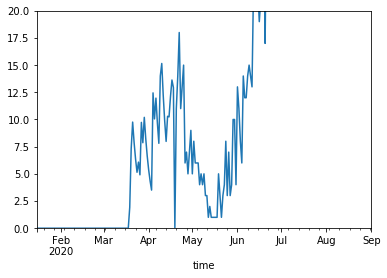

In [15]:
ax = sim[sim['comp'] == 'diffI']['01001'].plot()
ax.set_ylim(0,20)

In [29]:
sim[sim['comp'] == 'diffI']['01001'].iloc[60:100]

time
2020-03-15     0.000000
2020-03-16     0.000000
2020-03-17     0.000000
2020-03-18     0.000000
2020-03-19     1.923077
2020-03-20     7.322485
2020-03-21     9.760469
2020-03-22     7.883456
2020-03-23     6.367406
2020-03-24     5.142905
2020-03-25     6.076962
2020-03-26     4.908315
2020-03-27     9.733639
2020-03-28     7.861786
2020-03-29    10.196058
2020-03-30     8.235277
2020-03-31     6.651570
2020-04-01     5.372422
2020-04-02     4.339264
2020-04-03     3.504790
2020-04-04    12.446177
2020-04-05    10.052681
2020-04-06    11.965627
2020-04-07     9.664545
2020-04-08     7.805979
2020-04-09    13.997137
2020-04-10    15.151533
2020-04-11    12.237777
2020-04-12     9.884358
2020-04-13     7.983520
2020-04-14    10.294382
2020-04-15    10.237770
2020-04-16    12.115122
2020-04-17    13.631445
2020-04-18    12.933090
2020-04-19     0.000000
2020-04-20    11.000000
2020-04-21    14.000000
2020-04-22    18.000000
2020-04-23    11.000000
Name: 01001, dtype: float64

In [115]:
sim = pq.read_table('model_output/USA_LockdownUK1918_sandia/000000001.seir.parquet').to_pandas()

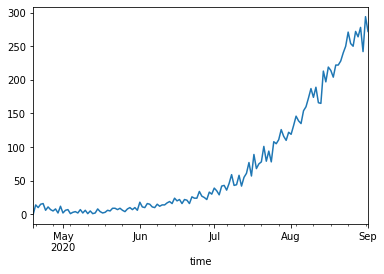

In [116]:
sim[sim['comp'] == 'diffI'].set_index('time', drop=True)['01001'].plot()

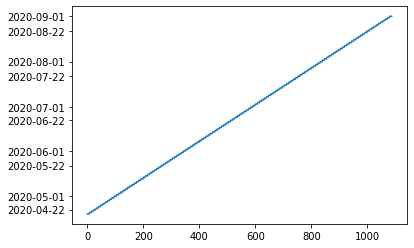

In [117]:
sim['time'].plot()

In [71]:
config.set_file('config.yml')

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
geodata_file=spatial_base_path / spatial_config["geodata"].get()
nodenames_key=spatial_config["nodenames"].get()
geodata = pd.read_csv(geodata_file, converters={nodenames_key: lambda x: str(x)})
past_dynamics = pd.read_csv('data/past_dynamics.csv', parse_dates=['time'])
#past_dynamics = past_dynamics[past_dynamics['time'] != max(past_dynamics['time'])]
folder = [x for x in Path('model_output/').glob('*') if not x.is_file()]

for fold in folder:
        print(f'loading {str(fold)[13:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            sim = pd.read_csv(filename)
            c = pd.concat([past_dynamics, sim])
            c.to_csv(filename)

        for filename in Path(str(fold)).rglob('*.parquet'):
            sim = pq.read_table(filename).to_pandas()
            sim = sim[sim['time'] != max(past_dynamics['time'])]
            #sim = sim.set_index('time', drop=True)
            c = pd.concat([past_dynamics, sim], ignore_index = True)
            #c['time'] = c.index
            only_in_sim = list(set(sim.columns) - set(past_dynamics.columns))
            only_in_pastdyn = list(set(past_dynamics.columns)- set(sim.columns))
            c.drop(only_in_pastdyn, inplace=True, axis=1)
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] != 'S'), only_in_sim] = 0
            pop_ois = []
            for nd in only_in_sim:
                pop_ois.append(float(geodata[geodata['geoid'] == nd].pop2010))
            c.loc[(c['time'] <= max(past_dynamics['time'])) & (c['comp'] == 'S'), only_in_sim] = pop_ois
            pa_df = pa.Table.from_pandas(c.round(), preserve_index = False)
            pa.parquet.write_table(pa_df,filename)
        print('DONE')

loading USA_LockdownUK1918_sandia ... DONE


In [90]:
c

,comp,01001,01003,01005,01007,01009,01011,01013,01015,01017,...,56029,56031,56033,56035,56037,56039,56041,56043,56045,time
0,S,54571.000000,182265.000000,27457.000000,22915.000000,57322.000000,10914.000000,20947.000000,118572.000000,34215.000000,...,28205.000000,8667.0,29116.000000,10247.000000,43806.000000,21294.000000,21118.000000,8533.000000,7208.0,2020-01-15
1,E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2020-01-15
2,I1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2020-01-15
3,I2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2020-01-15
4,I3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2020-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,diffI,10.237770,48.989025,16.337248,22.177786,9.445900,7.381234,7.461894,36.611201,83.158343,...,0.001350,0.0,0.267707,0.014147,2.072607,9.719141,2.411055,0.328521,0.0,2020-04-15
668,diffI,12.115122,51.106521,24.733931,17.912827,15.321688,5.961766,7.949991,35.339817,71.012508,...,0.001090,0.0,0.216225,0.011426,1.674029,7.850076,1.947391,0.265344,0.0,2020-04-16
669,diffI,13.631445,58.586036,21.900483,16.391130,18.144441,4.815273,10.267301,32.389852,78.510102,...,0.000881,0.0,0.174643,0.009229,1.352100,8.263523,1.572893,0.214316,0.0,2020-04-17
670,diffI,12.933090,68.473337,19.611928,13.238990,18.501279,5.812336,12.138974,31.930265,73.027390,...,0.000711,0.0,0.141058,0.007454,1.092081,6.674384,1.270413,0.173102,0.0,2020-04-18


In [73]:
past_dynamics[past_dynamics['comp'] == 'diffI'].set_index('time', drop=True)['01001']

time
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
2020-01-18      0.0
2020-01-19      0.0
              ...  
2020-08-28    443.0
2020-08-29    423.0
2020-08-30    470.0
2020-08-31    438.0
2020-09-01    461.0
Name: 01001, Length: 231, dtype: float64